# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для анализа есть исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры.

Дополнительно измерим *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

*Признаки:*
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

*Целевой признак*

- Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

In [2]:
try: # чтение файла с сайта
    df = pd.read_csv('/datasets/Churn.csv')
except: # чтение файла локально
    df = pd.read_csv('datasets/Churn.csv')

Обзор данных:

In [3]:
display(df.head())
print('--------------------------------------')
print('Размер:')
print(df.shape)
print('--------------------------------------')
print('Информация:')
print(df.info())
print('--------------------------------------')
print('Дубликаты:')
print(df.duplicated().sum())
print('--------------------------------------')
print('Пропуски:')
print(df.isna().sum())
print('--------------------------------------')
print('Описание данных:')
display(df.describe(include='all'))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


--------------------------------------
Размер:
(10000, 14)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


Дубликатов нет. Типы данных соответствуют оптимальным. Пропуски есть в столбце 'Tenure', который хранит информацию, сколько лет человек является клиентом банка.

В датасете есть столбец, который повторяет индекс. Он не несёт информации, удалим его.

In [4]:
df = df.drop('RowNumber', axis=1) # из исходного датасета убираем номер строки.

По описанию данных, названия столбцов написаны в "верблюжьем регистре". Проверим. 

In [5]:
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

Названия столбцов заменим на 'змеиный регистр'.

In [6]:
df.columns = df.columns.str.replace(r"([a-z])([A-Z])", r"\1 \2").str.lower().str.replace(' ', '_')
df.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Посмотрим на пропуски в столбце 'tenure'.

In [7]:
df.loc[df['tenure'].isna()].head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Остальные данные в этих ячейках нормальные, информативные.

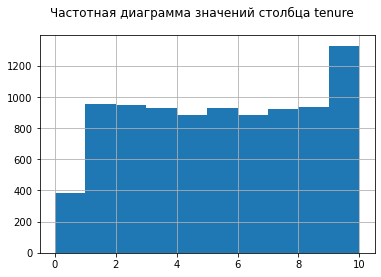

In [8]:
df['tenure'].hist()
plt.suptitle('Частотная диаграмма значений столбца tenure')
plt.show;

Посмотрим на числа в данных:

In [9]:
df.describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Сравним со значениями в строках с пропусками:

In [10]:
df.loc[df['tenure'].isna()].describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,9.090000e+02,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,1.568981e+07,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,7.511225e+04,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,1.556581e+07,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,1.562658e+07,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,1.568687e+07,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,1.575680e+07,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,1.581569e+07,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


Все значения средних, медиан близки. Выборка не выбивается из общей. 
Заполним пустые значения медианным, чтобы не сместить выборку.

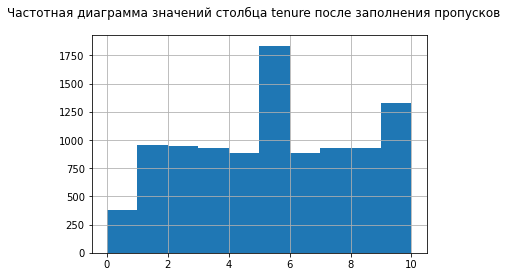

In [11]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median())
df['tenure'].hist()
plt.suptitle('Частотная диаграмма значений столбца tenure после заполнения пропусков')
plt.show;

В таблице есть столбец с фамилией. Очевидно, для исследования эта информация не нужна. Отделим фамилии и номер пользователя в отдельный датафрейм, с которым можно будет по номеру получить фамилию.

Номер пользователя установим в качестве индекса, чтобы он не участвовал в исследовании, но сохранился.

In [12]:
df_names = df[['customer_id', 'surname']]    
df = df.drop('surname', axis=1)              
df = df.set_index('customer_id')             
display(df_names.head())                     
display(df.head())                           

,customer_id,surname
0,15634602,Hargrave
1,15647311,Hill
2,15619304,Onio
3,15701354,Boni
4,15737888,Mitchell


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,,,,,,,,,,,
15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Разделение данных на выборки

Разделим исходные данные на обучающую, валидационную и тестовую выборки.
- Обучающая выборка - 60%
- Валидационная выборка - 20%
- Тестовая выборка - 20%

Отделим тестовую выборку:

In [13]:
df_train, df_test = train_test_split(
    df, test_size=0.2, # разделяем 80% и 20% датасета
    random_state=12345, 
    stratify=df['exited'] # так, чтобы соотношение в целевом столбце осталось неизменным
)
print(df_test.shape) # контроль размера тестовой выборки
print(df_train.shape) # контроль размера остальной выборки

(2000, 11)
(8000, 11)


Проверим равномерность распределения целевого значения:

In [14]:
print(df_train['exited'].mean())
print(df_test['exited'].mean())

0.20375
0.2035


Всё совпадает.

### Подготовка признаков

Извлечём признаки и целевой признак:

In [15]:
features_train = df_train.drop(['exited'], axis=1) # извлекаем признаки
target_train = df_train['exited'] # целевой признак

Преобразуем категориальные признаки при помощи One-Hot Encoder, a числовые StandardScaler. Чтобы одновременно применить их на один набор признаков, используем  ColumnTransformer.

In [16]:
OHE = OneHotEncoder(drop = 'first')
scaler = StandardScaler()

cat_cols = ['geography', 'gender']
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)],
                                remainder='passthrough'
                               )

ohe_features_train = transformer.fit_transform(features_train)

# для моделей, умеющих обрабатывать категориальные признаки, применим только Scaler
features_train[num_cols] = scaler.fit_transform(features_train[num_cols]) 

In [17]:
print("Было/стало:", features_train.shape, ohe_features_train.shape)

Было/стало: (8000, 10) (8000, 11)


In [18]:
features_train.head(2)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
customer_id,,,,,,,,,,
15721582,-0.061427,Germany,Female,0.106098,-0.366474,0.010530,0.805878,1,1,0.267707
15734634,-0.443298,Spain,Female,-1.139433,-0.002321,0.388533,-0.911497,0,0,-1.612531


## Исследование задачи

### Модель логистическая регрессия

Обучим модель и проверим точность:

In [19]:
LogReg = LogisticRegression(max_iter = 1000, random_state = 12345)
params = {'C':[1,5, 10, 20, 30, 40, 50],
          'penalty': ['l1', 'l2'],
          'solver':['liblinear', 'saga']}
gridlog = GridSearchCV(LogReg, params, cv=3, scoring='f1', refit = True)
gridlog.fit(ohe_features_train, target_train)
print('Наилучшие гиперпараметры: ', gridlog.best_params_)
f1_log_reg = gridlog.best_score_
print("F1-мера наилучшей модели:", round(f1_log_reg, 4))
accuracy_log_reg = accuracy_score(
    target_train, 
    gridlog.best_estimator_.predict(ohe_features_train))
print("Accuracy наилучшей модели:", round(accuracy_log_reg, 4))
print("ROC-AUC наилучшей модели:", round(roc_auc_score(
    target_train, 
    gridlog.best_estimator_.predict_proba(ohe_features_train)[:, 1]), 4))

Наилучшие гиперпараметры:  {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}
F1-мера наилучшей модели: 0.3222
Accuracy наилучшей модели: 0.8132
ROC-AUC наилучшей модели: 0.7637


Функция для отрисовки графика ROC-AUC:

In [20]:
def ROC_plot(model, fpr, tpr):
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая модели')
    plt.show() 

Посмотрим на график:

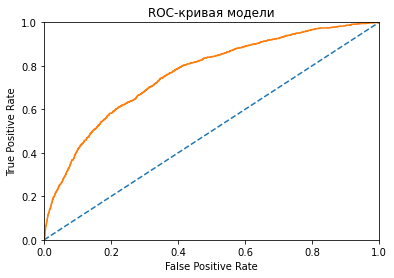

In [21]:
LogReg = gridlog.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    LogReg.predict_proba(ohe_features_train)[:, 1]) 
ROC_plot(LogReg, fpr, tpr)

### Модель дерево решений

Подбор оптимальной глубины дерева кросс-валидацией:

In [22]:
Tree = DecisionTreeClassifier(random_state=12345)
parametrs = { 'max_depth' : range (1, 13, 1)}
grid_Tree = GridSearchCV(Tree, parametrs, cv=3, scoring = 'f1')
grid_Tree.fit(ohe_features_train, target_train)

best_parametrs = grid_Tree.best_params_
print('Наилучшее количество деревьев', best_parametrs)

best_f1_tree = grid_Tree.best_score_
print("F1 наилучшей модели:", round(best_f1_tree, 4))

best_accuracy_tree = accuracy_score(
    target_train, 
    grid_Tree.best_estimator_.predict(ohe_features_train))
print("Accuracy наилучшей модели:", round(best_accuracy_tree, 4))

print("ROC-AUC наилучшей модели:", round(roc_auc_score(
    target_train, 
    grid_Tree.best_estimator_.predict_proba(ohe_features_train)[:, 1]), 4))

Наилучшее количество деревьев {'max_depth': 7}
F1 наилучшей модели: 0.5564
Accuracy наилучшей модели: 0.8718
ROC-AUC наилучшей модели: 0.8782


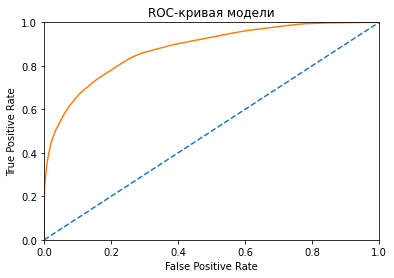

In [23]:
Tree = grid_Tree.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    Tree.predict_proba(ohe_features_train)[:, 1]) 
ROC_plot(Tree, fpr, tpr)

### Модель cлучайный лес

Подбор гиперпараметров при помощи GridSearch:

In [24]:
Forest = RandomForestClassifier(random_state=12345)
parametrs = { 'n_estimators'    : range (5, 20, 2),
              'max_depth'       : range (1, 13, 2),
              'min_samples_leaf': range (1,10)}
grid_Forest = GridSearchCV(Forest, parametrs, cv=3, scoring = 'f1', n_jobs = -1)
grid_Forest.fit(ohe_features_train, target_train)

best_parametrs = grid_Forest.best_params_
print('Наилучшие гиперпараметры:', best_parametrs)

best_f1_forest = grid_Forest.best_score_
print("F1 наилучшей модели:", round(best_f1_forest, 4))

best_accuracy_forest = accuracy_score(
    target_train, 
    grid_Forest.best_estimator_.predict(ohe_features_train))
print("Accuracy наилучшей модели:", round(best_accuracy_forest, 4))

print("ROC-AUC наилучшей модели:", round(roc_auc_score(
    target_train, 
    grid_Forest.best_estimator_.predict_proba(ohe_features_train)[:, 1]), 4))

Наилучшие гиперпараметры: {'max_depth': 11, 'min_samples_leaf': 4, 'n_estimators': 15}
F1 наилучшей модели: 0.5657
Accuracy наилучшей модели: 0.8946
ROC-AUC наилучшей модели: 0.9448


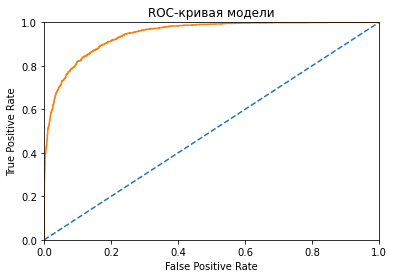

In [25]:
Forest = grid_Forest.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    Forest.predict_proba(ohe_features_train)[:, 1]) 
ROC_plot(Forest, fpr, tpr)

### Константная модель

Проверим, как часто в целевом признаке встречается класс «1» или «0»

0    0.7963
1    0.2037
Name: exited, dtype: float64


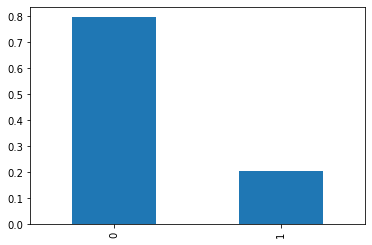

In [26]:
class_frequency = df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Значение "0" встречается гораздо чаще, данные не сбалансированы.

Создадим константную модель, которая всегда предсказывает самое частое значение.

Сравним её работу с предыдущими моделями.

In [27]:
target_pred_constant = pd.Series([0] * len(target_train))
accuracy_constant = accuracy_score(target_train, target_pred_constant)
f1_constant = f1_score(target_train, target_pred_constant)

Собираем результаты работы моделей наглядно:

In [28]:
results = {
    'model': ['Константная модель', 'Логистическая регрессия', 'Решающее дерево', 'Случайный лес'], 
    'accuracy': [accuracy_constant, accuracy_log_reg, best_accuracy_tree, best_accuracy_forest], 
    'f1-мера': [f1_constant, f1_log_reg, best_f1_tree, best_f1_forest]
}
mod_compare = pd.DataFrame(data=results).set_index('model')
mod_compare

,accuracy,f1-мера
model,,
Константная модель,0.796250,0.000000
Логистическая регрессия,0.813250,0.322179
Решающее дерево,0.871750,0.556372
Случайный лес,0.894625,0.565673


Модели проходят проверку на адекватность.

## Борьба с дисбалансом

### Aргумент class_weight

Чтобы сбалансировать классы, можно использовать из библиотеки sklearn аргумент class_weight.

Если указать "class_weight='balanced'", алгоритм посчитает, во сколько раз
класс «0» встречается чаще класса «1». 

#### Модель логистическая регрессия

Обучим модель и проверим точность:

In [29]:
LogReg = LogisticRegression(class_weight='balanced', # сбалансировать классы
                            max_iter = 1000, random_state = 12345)
params = {'C':[1,5, 10, 20, 30, 40, 50],
          'penalty': ['l1', 'l2'],
          'solver':['liblinear', 'saga']}
gridlog_bal = GridSearchCV(LogReg, params, cv=3, scoring='f1', refit = True)
gridlog_bal.fit(ohe_features_train, target_train)
print('Наилучшие гиперпараметры: ', gridlog_bal.best_params_)
bal_f1_log_reg = gridlog_bal.best_score_
print("F1-мера наилучшей модели:", round(bal_f1_log_reg, 4))
bal_accuracy_log_reg = accuracy_score(
    target_train, 
    gridlog_bal.best_estimator_.predict(ohe_features_train))
print("Accuracy наилучшей модели:", round(bal_accuracy_log_reg, 4))
print("ROC-AUC наилучшей модели:", round(roc_auc_score(
    target_train, 
    gridlog_bal.best_estimator_.predict_proba(ohe_features_train)[:, 1]), 4))

Наилучшие гиперпараметры:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
F1-мера наилучшей модели: 0.4846
Accuracy наилучшей модели: 0.7066
ROC-AUC наилучшей модели: 0.7671


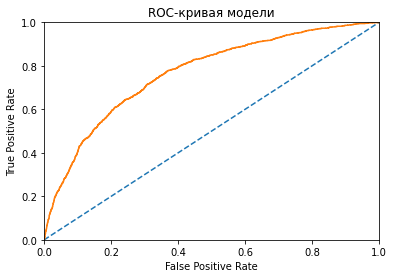

In [30]:
LogReg = gridlog_bal.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    LogReg.predict_proba(ohe_features_train)[:, 1]) 
ROC_plot(LogReg, fpr, tpr)

#### Модель дерево решений

Подбор оптимальной глубины дерева кросс-валидацией:

In [31]:
Tree = DecisionTreeClassifier(class_weight='balanced', # сбалансировать классы
                              random_state=12345)
parametrs = { 'max_depth' : range (1, 13, 1)}
grid_Tree_bal = GridSearchCV(Tree, parametrs, cv=3, scoring = 'f1')
grid_Tree_bal.fit(ohe_features_train, target_train)

best_parametrs = grid_Tree_bal.best_params_
print('Наилучшее количество деревьев', best_parametrs)

bal_f1_tree = grid_Tree_bal.best_score_
print("F1 наилучшей модели:", round(bal_f1_tree, 4))

bal_accuracy_tree = accuracy_score(
    target_train, 
    grid_Tree_bal.best_estimator_.predict(ohe_features_train))
print("Accuracy наилучшей модели:", round(bal_accuracy_tree, 4))

print("ROC-AUC наилучшей модели:", round(roc_auc_score(
    target_train, 
    grid_Tree_bal.best_estimator_.predict_proba(ohe_features_train)[:, 1]), 4))

Наилучшее количество деревьев {'max_depth': 7}
F1 наилучшей модели: 0.5615
Accuracy наилучшей модели: 0.7884
ROC-AUC наилучшей модели: 0.8825


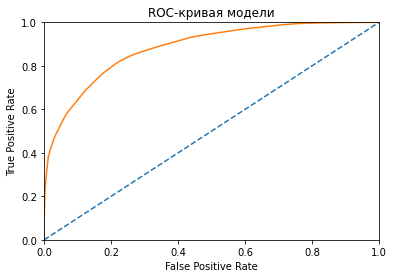

In [32]:
Tree = grid_Tree_bal.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    Tree.predict_proba(ohe_features_train)[:, 1]) 
ROC_plot(Tree, fpr, tpr)

#### Модель cлучайный лес

Подбор гиперпараметров при помощи GridSearch:

In [33]:
Forest = RandomForestClassifier(class_weight='balanced',
                                random_state=12345)
parametrs = { 'n_estimators'    : range (5, 20, 2),
              'max_depth'       : range (1, 13, 2),
              'min_samples_leaf': range (1,10)}
grid_Forest_bal = GridSearchCV(Forest, parametrs, cv=3, scoring = 'f1', n_jobs = -1)
grid_Forest_bal.fit(ohe_features_train, target_train)

best_parametrs = grid_Forest_bal.best_params_
print('Наилучшие гиперпараметры:', best_parametrs)

bal_f1_forest = grid_Forest_bal.best_score_
print("F1 наилучшей модели:", round(bal_f1_forest, 4))

bal_accuracy_forest = accuracy_score(
    target_train, 
    grid_Forest_bal.best_estimator_.predict(ohe_features_train))
print("Accuracy наилучшей модели:", round(bal_accuracy_forest, 4))

print("ROC-AUC наилучшей модели:", round(roc_auc_score(
    target_train, 
    grid_Forest_bal.best_estimator_.predict_proba(ohe_features_train)[:, 1]), 4))

Наилучшие гиперпараметры: {'max_depth': 9, 'min_samples_leaf': 4, 'n_estimators': 15}
F1 наилучшей модели: 0.6161
Accuracy наилучшей модели: 0.8614
ROC-AUC наилучшей модели: 0.9254


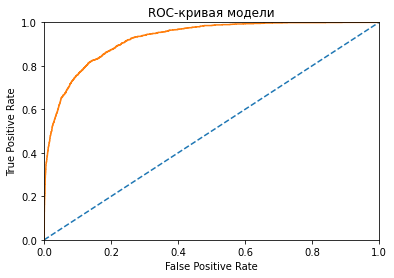

In [34]:
Forest = grid_Forest_bal.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    Forest.predict_proba(ohe_features_train)[:, 1]) 
ROC_plot(Forest, fpr, tpr)

### Модель CatBoostClassifier

Подбор гиперпараметров при помощи GridSearch:

In [35]:
%%time
CBC = CatBoostClassifier(random_seed  = 12345,
                        loss_function = 'Logloss',
                        custom_metric = 'F1',
                        cat_features  = cat_cols
                        )
parameter_dist={'depth'           : [3, 4, 5],
                'learning_rate'   : [0.05, 0.1, 0.2, 0.3],
                'border_count'    : [150, 250],
                'iterations'      : [100, 200, 300]
                }
Grid_CBC = GridSearchCV(CBC, parameter_dist, cv=5, n_jobs=-1, verbose=False, scoring = 'f1')
Grid_CBC.fit(features_train, target_train, plot = False, verbose = 50)
print("Наилучшие гиперпараметры:", Grid_CBC.best_params_)
print("F1-мера наилучшей модели:", round(Grid_CBC.best_score_, 4))
accuracy_cat = accuracy_score(
    target_train, 
    Grid_CBC.best_estimator_.predict(features_train))
print("Accuracy наилучшей модели:", round(accuracy_cat, 4))

print("ROC-AUC наилучшей модели:", round(roc_auc_score(
    target_train, 
    Grid_CBC.best_estimator_.predict_proba(features_train)[:, 1]), 4))

0:	learn: 0.6191631	total: 231ms	remaining: 45.9s
50:	learn: 0.3270362	total: 4.86s	remaining: 14.2s
100:	learn: 0.3133374	total: 9.36s	remaining: 9.17s
150:	learn: 0.3035414	total: 14s	remaining: 4.54s
199:	learn: 0.2948146	total: 18.6s	remaining: 0us
Наилучшие гиперпараметры: {'border_count': 250, 'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
F1-мера наилучшей модели: 0.5996
Accuracy наилучшей модели: 0.882
ROC-AUC наилучшей модели: 0.8986
Wall time: 45min 45s


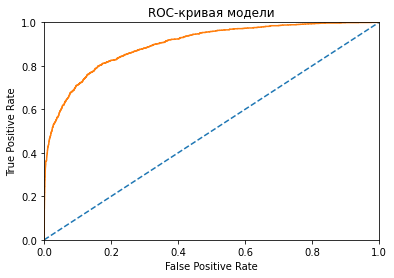

In [36]:
CBCg = Grid_CBC.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_train, 
    CBCg.predict_proba(features_train)[:, 1]) 
ROC_plot(CBCg, fpr, tpr)

#### Результаты моделей


Собираем результаты работы моделей наглядно:

In [37]:
results = {
    'model': ['Логистическая регрессия баланс.', 'Решающее дерево баланс.', 'Случайный лес баланс.', 'Catboost'], 
    'accuracy': [bal_accuracy_log_reg, bal_accuracy_tree, bal_accuracy_forest, accuracy_cat], 
    'f1-мера': [bal_f1_log_reg, bal_f1_tree, bal_f1_forest, Grid_CBC.best_score_]
}
mod_compare_balanced = pd.DataFrame(data=results).set_index('model')
full_mod_compare = pd.concat([mod_compare, mod_compare_balanced]).sort_values(by = 'f1-мера')
full_mod_compare

,accuracy,f1-мера
model,,
Константная модель,0.796250,0.000000
Логистическая регрессия,0.813250,0.322179
Логистическая регрессия баланс.,0.706625,0.484629
Решающее дерево,0.871750,0.556372
Решающее дерево баланс.,0.788375,0.561504
Случайный лес,0.894625,0.565673
Catboost,0.882000,0.599639
Случайный лес баланс.,0.861375,0.616133


Сравним значения f1-меры и точности разных моделей:

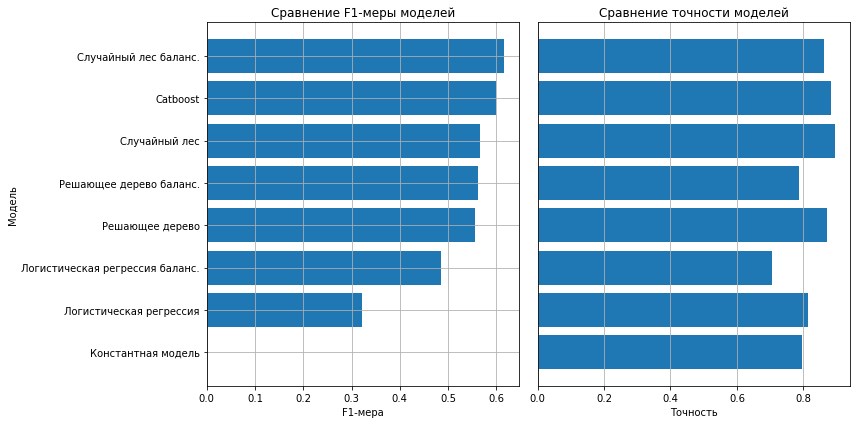

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
ax1.barh(width = full_mod_compare['f1-мера'], y = full_mod_compare.index)
ax1.grid(True)
ax1.set_title('Сравнение F1-меры моделей')
ax1.set_xlabel('F1-мера')
ax1.set_ylabel('Модель')

ax2.barh(width = full_mod_compare['accuracy'], y = full_mod_compare.index)
ax2.grid(True)
ax2.set_title('Сравнение точности моделей')
ax2.set_xlabel('Точность')
ax2.set_yticks([])
plt.tight_layout()
plt.show;

Наибольшее значение F1-меры достигнуто моделью Случайный лес с балансом классов и составляет 0.616.

Целевое значение F1-меры равно 0.59.

Обучение прошло успешно.

## Тестирование модели

Наилучшая F1-мера была у модели случайный лес.

Извлечём признаки и целевой признак из тестовой выборки:

In [39]:
features_test = df_test.drop(['exited'], axis=1) # извлекаем признаки
ohe_features_test = transformer.transform(features_test) # масштабирование и кодирование
target_test = df_test['exited'] # целевой признак

Работа модели:

In [40]:
model = grid_Forest_bal.best_estimator_
model.fit(ohe_features_train, target_train)
predicted_test = model.predict(ohe_features_test)
probabilities_test = model.predict_proba(ohe_features_test) 
probabilities_one_test = probabilities_test[:, 1] 
accuracy_final = model.score(ohe_features_test, target_test)
f1_final = f1_score(target_test, predicted_test)
auc_roc_final = roc_auc_score(target_test, probabilities_one_test)
print("F1-мера:", f1_final)
print("Accuracy:", accuracy_final)
print("AUC-ROC:", auc_roc_final)

F1-мера: 0.6321467098166127
Accuracy: 0.8295
AUC-ROC: 0.8658057132633404


Построим ROC-кривую.

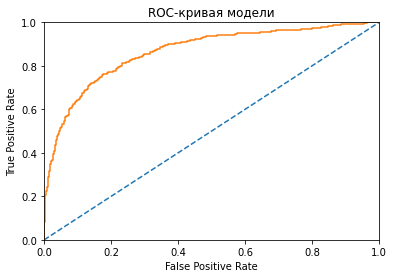

In [41]:
model = grid_Forest_bal.best_estimator_
fpr, tpr, thresholds = roc_curve(
    target_test, 
    model.predict_proba(ohe_features_test)[:, 1]) 
ROC_plot(model, fpr, tpr)

Посмотрим матрицу ошибок:

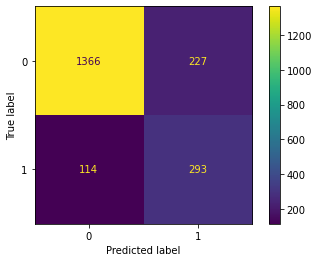

In [42]:
prediction = model.predict(ohe_features_test)
ConfusionMatrixDisplay(confusion_matrix(target_test, prediction)).plot();

Из всех 2000 записей предсказано, что:
   - 1 294 не планируют расторгнуть договор, и из них:
     - 1366 предсказаны верно,
     - 114 ошибок(клиент планирует уйти, но модель этого не предугадала);
   - 706 планируют расторгнуть договор, и из них:
     - 293 предсказаны верно;
     - 227 ошибок (модель предсказала уход лояльного клиента)

Посмотрим на важность признаков по мнению модели:

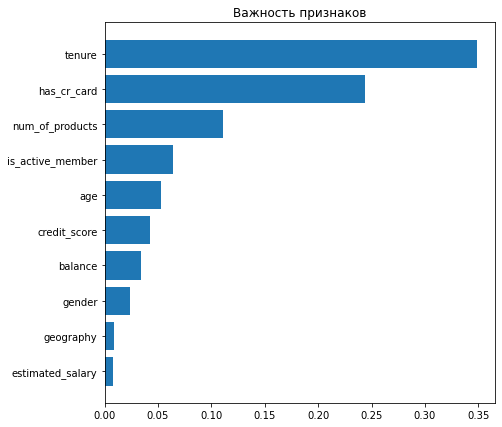

In [44]:
labels = features_test.columns

feature_importances = pd.DataFrame(
    zip(labels, model.feature_importances_), 
    columns = ['feature', 'importance']
    ).sort_values(by = 'importance', ascending = False)
    
plt.figure(figsize = (7, 7))
plt.title('Важность признаков')
feature_importances = feature_importances.sort_values(by = 'importance')
plt.barh(y = feature_importances.feature, 
         width = feature_importances['importance'])
plt.show;

## Вывод:

Чтобы сохранить клиентов, которые планируют уйти, разработана модель машинного обучения. Она предсказывает вероятный уход клиента. 

Из 2000 записей тестовой выборки предсказано, что:
   - 1 294 не планируют расторгнуть договор, и из них:
     - 1366 предсказаны верно,
     - 227 ошибок(клиент планирует уйти, но модель этого не предугадала);
   - 706 планируют расторгнуть договор, и из них:
     - 293 предсказаны верно;
     - 114 ошибок (модель предсказала уход лояльного клиента)

Самым важным признаком для предсказания оказалось время с заключения договора, на втором месте - наличие кредитной карты, далее - количество продуктов, которыми пользуется клиент.

Значение F1-меры на тестовой выборке равно 0.632.

Необходимо было достигнуть значения F1-меры 0.59, значит, обучение прошло успешно.